# Iron Condor Strategy

Recreated from the original iron condor notebook, updated for the modern codebase and SPY data.

An [iron condor](https://www.investopedia.com/terms/i/ironcondor.asp) is a 4-leg options strategy that profits from range-bound markets:
1. **BUY** deep OTM put (protection)
2. **SELL** near-ATM put (premium collection)
3. **SELL** near-ATM call (premium collection)
4. **BUY** deep OTM call (protection)

Max profit = net premium collected. Max loss = width of wing minus premium.

In [1]:
import math
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

PROJECT_ROOT = os.path.realpath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, PROJECT_ROOT)
os.chdir(PROJECT_ROOT)

from options_portfolio_backtester import BacktestEngine as Backtest, Stock, Type, Direction
from options_portfolio_backtester import HistoricalOptionsData, TiingoData
from options_portfolio_backtester import Strategy, StrategyLeg
from options_portfolio_backtester import summary
from options_portfolio_backtester.analytics.charts import returns_chart, returns_histogram, monthly_returns_heatmap

sns.set_theme(style='whitegrid', palette='muted')
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 6)
plt.rcParams['figure.dpi'] = 110

print('Setup done.')

Setup done.


## Load Data

In [2]:
options_data = HistoricalOptionsData('data/processed/options.csv')
stocks_data = TiingoData('data/processed/stocks.csv')
schema = options_data.schema

print(f'Date range: {stocks_data.start_date} to {stocks_data.end_date}')
print(f'Options rows: {len(options_data):,}')
print(f'Stock rows: {len(stocks_data):,}')

Date range: 2008-01-02 00:00:00 to 2025-12-12 00:00:00
Options rows: 24,681,663
Stock rows: 4,513


## Define Iron Condor Strategy

- **Leg 1**: BUY deep OTM put (strike <= 85% of spot)
- **Leg 2**: SELL near-ATM put (strike 90%-100% of spot)
- **Leg 3**: SELL near-ATM call (strike 100%-110% of spot)
- **Leg 4**: BUY deep OTM call (strike >= 115% of spot)

Entry: 35-60 DTE. Exit: DTE <= 35 (hold ~1 month).

In [3]:
DTE_MIN, DTE_MAX, EXIT_DTE = 35, 60, 35

iron_condor = Strategy(schema)

# Leg 1: BUY deep OTM put (protection)
leg1 = StrategyLeg('leg_1', schema, option_type=Type.PUT, direction=Direction.BUY)
leg1.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= DTE_MIN) & (schema.dte <= DTE_MAX) &
    (schema.strike <= 0.85 * schema.underlying_last)
)
leg1.exit_filter = (schema.dte <= EXIT_DTE)

# Leg 2: SELL near-ATM put (premium)
leg2 = StrategyLeg('leg_2', schema, option_type=Type.PUT, direction=Direction.SELL)
leg2.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= DTE_MIN) & (schema.dte <= DTE_MAX) &
    (schema.strike >= 0.90 * schema.underlying_last) &
    (schema.strike <= schema.underlying_last)
)
leg2.exit_filter = (schema.dte <= EXIT_DTE)

# Leg 3: SELL near-ATM call (premium)
leg3 = StrategyLeg('leg_3', schema, option_type=Type.CALL, direction=Direction.SELL)
leg3.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= DTE_MIN) & (schema.dte <= DTE_MAX) &
    (schema.strike >= schema.underlying_last) &
    (schema.strike <= 1.10 * schema.underlying_last)
)
leg3.exit_filter = (schema.dte <= EXIT_DTE)

# Leg 4: BUY deep OTM call (protection)
leg4 = StrategyLeg('leg_4', schema, option_type=Type.CALL, direction=Direction.BUY)
leg4.entry_filter = (
    (schema.underlying == 'SPY') &
    (schema.dte >= DTE_MIN) & (schema.dte <= DTE_MAX) &
    (schema.strike >= 1.15 * schema.underlying_last)
)
leg4.exit_filter = (schema.dte <= EXIT_DTE)

iron_condor.add_legs([leg1, leg2, leg3, leg4])
print(f'Iron Condor strategy: {len(iron_condor.legs)} legs')

Iron Condor strategy: 4 legs


## Run Backtest

Allocate 95% to SPY stocks, 5% to the iron condor strategy.

In [4]:
bt = Backtest({'stocks': 0.95, 'options': 0.05, 'cash': 0.0}, initial_capital=1_000_000)
bt.stocks = [Stock('SPY', 1.0)]
bt.stocks_data = stocks_data
bt.options_strategy = iron_condor
bt.options_data = options_data
bt.run(rebalance_freq=1)

print(f'Trades executed: {len(bt.trade_log)}')

Trades executed: 4


## Results

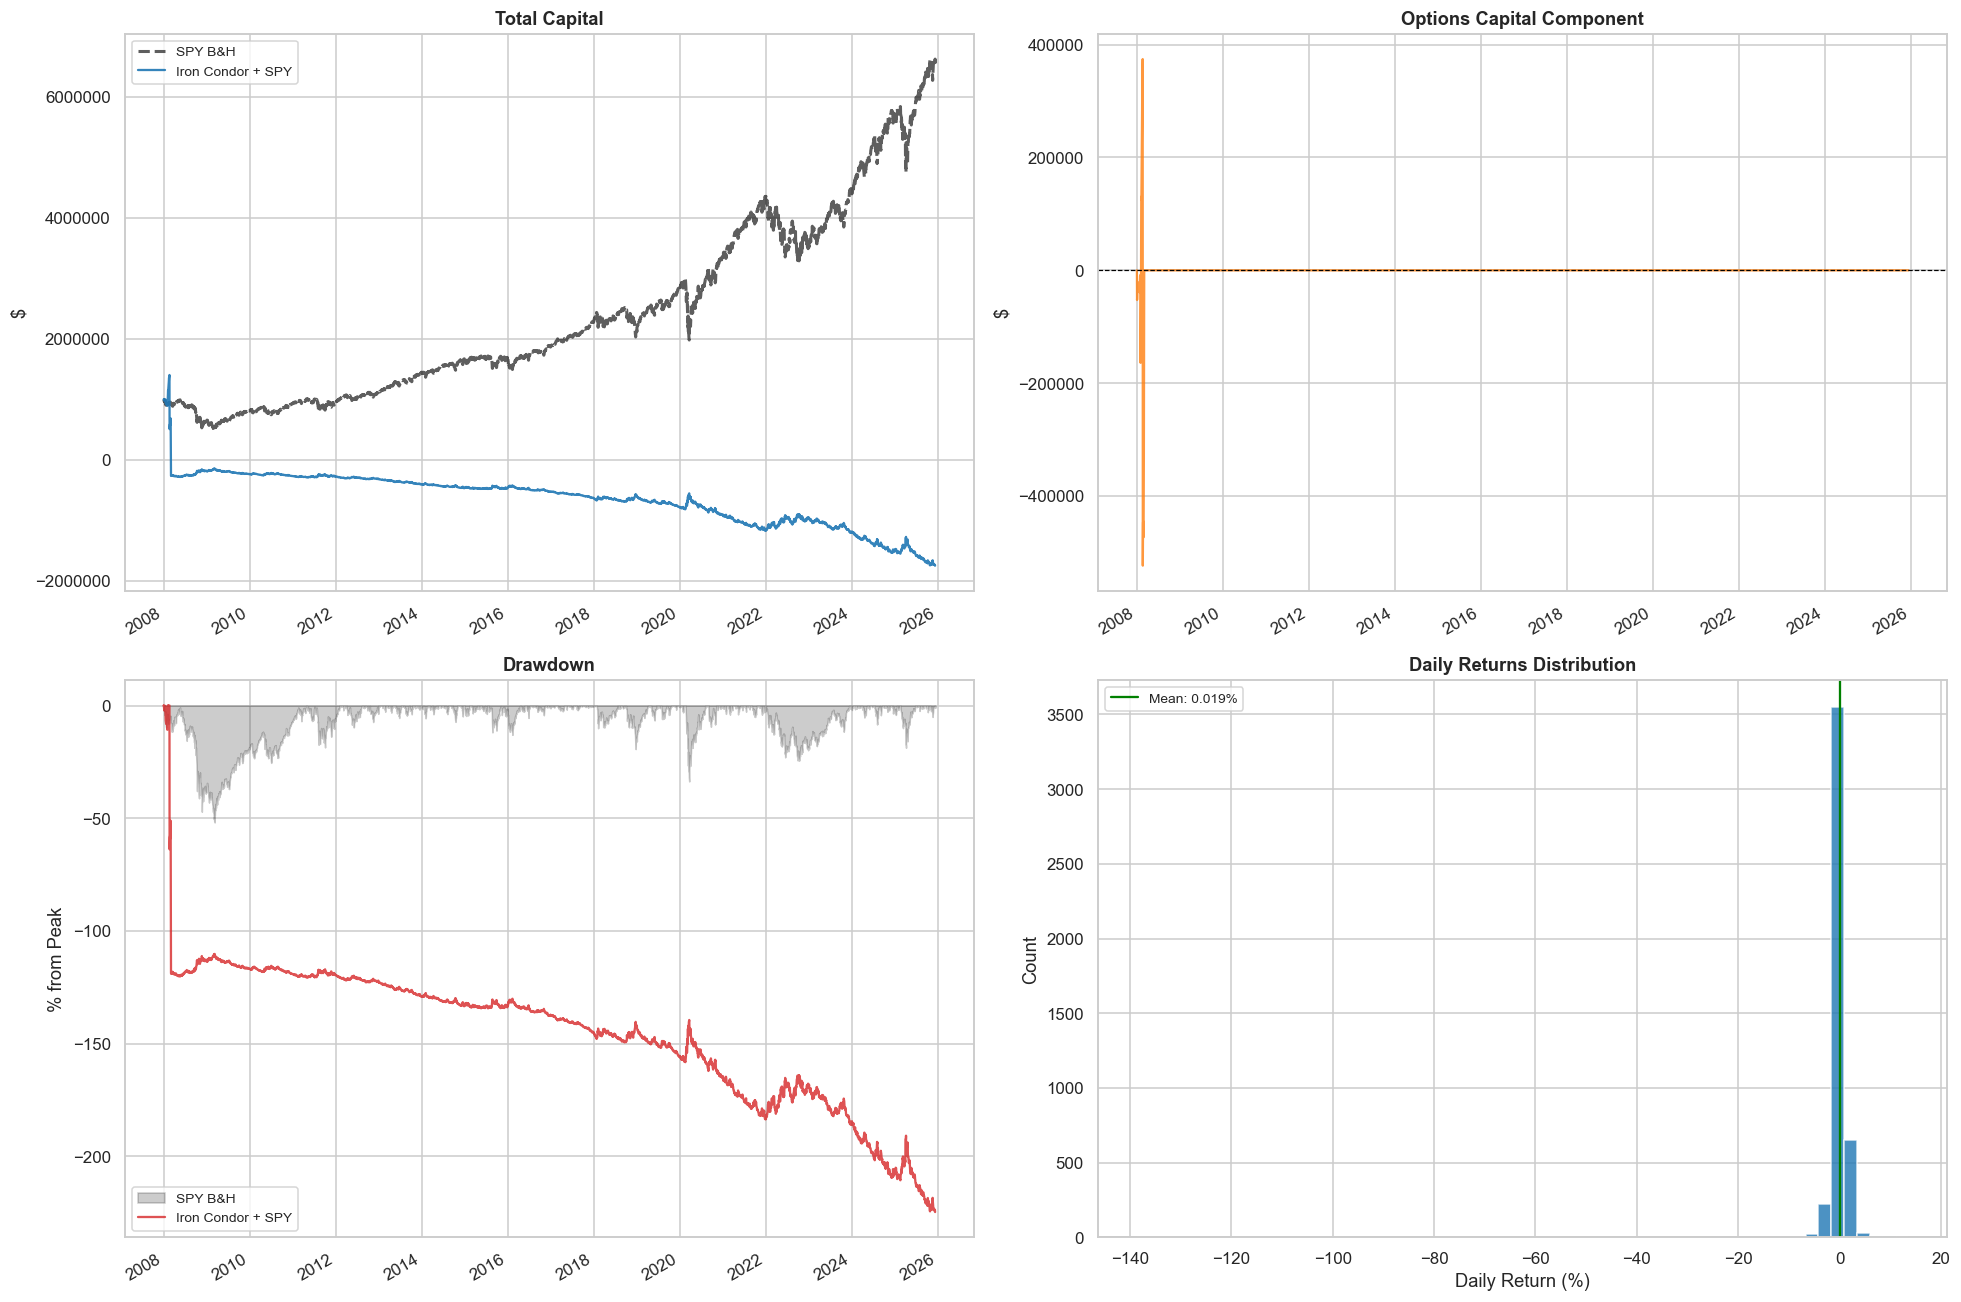

Iron Condor + SPY: -275.0% total, nan%/yr, -224.7% max DD
SPY B&H:           555.5% total, 11.05%/yr
Excess:            +nan%/yr


In [5]:
spy = stocks_data._data[stocks_data._data['symbol'] == 'SPY'].set_index('date')['adjClose'].sort_index()
spy_norm = spy / spy.iloc[0] * 1_000_000

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Capital curve
ax = axes[0, 0]
ax.plot(spy_norm.index, spy_norm.values, 'k--', lw=2, label='SPY B&H', alpha=0.7)
bt.balance['total capital'].plot(ax=ax, label='Iron Condor + SPY', color='#1f77b4', alpha=0.9, lw=1.5)
ax.set_title('Total Capital', fontsize=12, fontweight='bold')
ax.set_ylabel('$')
ax.ticklabel_format(style='plain', axis='y')
ax.legend(fontsize=9)

# Options capital
ax = axes[0, 1]
bt.balance['options capital'].plot(ax=ax, color='#ff7f0e', alpha=0.8, lw=1.5)
ax.set_title('Options Capital Component', fontsize=12, fontweight='bold')
ax.set_ylabel('$')
ax.axhline(0, color='black', lw=0.8, ls='--')

# Drawdown
ax = axes[1, 0]
total_cap = bt.balance['total capital']
dd = (total_cap - total_cap.cummax()) / total_cap.cummax() * 100
spy_dd = (spy - spy.cummax()) / spy.cummax() * 100
ax.fill_between(spy_dd.index, spy_dd.values, 0, alpha=0.2, color='black', label='SPY B&H')
dd.plot(ax=ax, color='#d62728', alpha=0.8, label='Iron Condor + SPY')
ax.set_title('Drawdown', fontsize=12, fontweight='bold')
ax.set_ylabel('% from Peak')
ax.legend(fontsize=9)

# Daily returns histogram
ax = axes[1, 1]
daily_ret = bt.balance['% change'].dropna()
ax.hist(daily_ret * 100, bins=60, color='#1f77b4', edgecolor='white', alpha=0.8)
ax.set_title('Daily Returns Distribution', fontsize=12, fontweight='bold')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Count')
ax.axvline(daily_ret.mean() * 100, color='green', lw=1.5, ls='-',
           label=f'Mean: {daily_ret.mean()*100:.3f}%')
ax.legend(fontsize=9)

plt.tight_layout()
plt.show()

# Key metrics
total_ret = (bt.balance['accumulated return'].iloc[-1] - 1) * 100
years = (spy.index[-1] - spy.index[0]).days / 365.25
annual_ret = ((1 + total_ret / 100) ** (1 / years) - 1) * 100
spy_total = (spy.iloc[-1] / spy.iloc[0] - 1) * 100
spy_annual = ((1 + spy_total / 100) ** (1 / years) - 1) * 100

print(f'Iron Condor + SPY: {total_ret:.1f}% total, {annual_ret:.2f}%/yr, {dd.min():.1f}% max DD')
print(f'SPY B&H:           {spy_total:.1f}% total, {spy_annual:.2f}%/yr')
print(f'Excess:            {annual_ret - spy_annual:+.2f}%/yr')

In [6]:
# Trade summary
if len(bt.trade_log) > 0:
    summary(bt.trade_log, bt.balance)

In [7]:
# Interactive returns chart
returns_chart(bt.balance)

alt.VConcatChart(...)

In [8]:
monthly_returns_heatmap(bt.balance)

alt.Chart(...)

## Analysis

The iron condor is an income strategy that collects premium from selling near-ATM options while buying OTM protection. It profits in range-bound markets but can lose significantly during sharp moves (crashes or melt-ups).

Key observations:
- **Net premium collection** provides steady income in calm markets
- **4-leg structure** limits max loss per trade (defined risk)
- **Vulnerable to gap moves** — 2008 GFC and 2020 COVID would have caused significant losses
- **Best suited for low-vol environments** where SPY stays range-bound